In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
rng = np.random.default_rng(12345)

inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']
SUMM_STAT_PATH = 'cell_inference/resources/geo_summ_stats.npy'
LFP_PATH = 'cell_inference/resources/geo_lfp.npy'
MEM_VOLT_PATH = 'cell_inference/resources/geo_mem_volt.npy'
run_flag = True
number_samples = 1000

xs = np.full((number_samples,1), 0.) if 'xs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
ys = np.full((number_samples,1), 0.) if 'ys' not in inf_list else rng.uniform(low=-2000, high=5000, size=(number_samples,1))
zs = np.full((number_samples,1), 50.) if 'zs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
alphas = np.full((number_samples,1), np.pi/4) if 'alphas' not in inf_list else rng.uniform(low=-(np.pi / 3), high=(np.pi / 3), size=(number_samples,1))
hs = np.full((number_samples,1), 1.) if 'hs' not in inf_list else rng.uniform(low=-1., high=1., size=(number_samples,1))
phis = np.full((number_samples,1), 0.) if 'phis' not in inf_list else rng.uniform(low=0, high=np.pi, size=(number_samples,1))
loc_param = np.concatenate((xs, ys, zs, alphas, hs, phis), axis=1)

r_s = np.full((number_samples,1), 8.0) if 'r_s' not in inf_list else rng.uniform(low=5, high=12, size=(number_samples,1))
l_t = np.full((number_samples,1), 600.0) if 'l_t' not in inf_list else rng.uniform(low=20., high=800., size=(number_samples,1))
r2_s = np.square(r_s)
clf = ClassifierBuilder()
clf.load_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")
gmax = clf.predict(np.column_stack((r2_s, l_t)))
r_t = np.full((number_samples,1), 1.25) if 'r_t' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r_d = np.full((number_samples,1), .28) if 'r_d' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r_tu = np.full((number_samples,1), .28) if 'r_tu' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
l_d = np.full((number_samples,1), 200.0) if 'l_d' not in inf_list else rng.normal(loc=((np.log(100) + np.log(300)) / 2), scale=((np.log(300) - np.log(100)) / 4), size=(number_samples,1))
geo_param = np.concatenate((r_s, l_t, r_t, r_d, r_tu, l_d), axis=1)

# geo_param = [8,600.,1.25,.28,.28,200.]
# geo_param = np.tile(geo_param, (number_samples, 1))

labels = np.concatenate((r_s, l_t, r_t, r_d, r_tu, l_d), axis=1)#np.concatenate((loc_param, geo_param), axis=1)
np.set_printoptions(suppress=True)
print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

(1000, 6)
(1000, 6)
(1000, 6)


In [3]:
from typing import Union, List, Tuple
from matplotlib.figure import Figure
from matplotlib.axes import Axes

import os.path
if not os.path.isfile(SUMM_STAT_PATH) or not os.path.isfile(LFP_PATH) or run_flag:
    hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
    groundtruth_lfp = np.array(hf.get('data'))
    hf.close()

    sim = Simulation(geometry = geo_standard, 
                     electrodes = params.ELECTRODE_POSITION, 
                     cell_type = CellTypes.ACTIVE, 
                     loc_param = loc_param, 
                     geo_param = geo_param,
                     spike_threshold = -20, 
                     gmax = gmax, 
                     scale = 1., 
                     ncell = number_samples)
    # sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,geo_param=geo_param,gmax=.001,scale=1000, ncell=ncell)  # gmax 0.001 -0.012
    sec_list = sim.cells[0].all

def plot_v(sim: Simulation, cell_idx: np.ndarray = np.array([0, 1]),
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    t = sim.t()
    v = sim.v('all')
    fig, axs = plt.subplots(nrows=cell_idx.size, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*cell_idx.size)
    for i,ax in enumerate(axs):
        ax.plot(t,v[i,:])
        ax.set_ylabel('Vm (mV)')
#         ax.legend(loc=1)
    axs[0].set_title('Membrane Voltage vs Time')
    axs[-1].set_xlabel('Time (ms)')
    plt.show()
    return fig, axs    

def valid_count(sim):
    # number of valid spiking cells
    nspk = sim.get_spike_number('all')
    print(nspk)
    nvalid = np.count_nonzero(nspk == 1)
    return nvalid

[2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 1 2
 2 1 1 2 2 2 2 2 2 2 2 1 1 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 

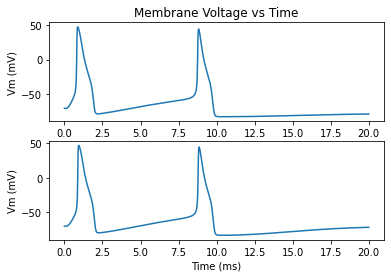

In [4]:
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

import os.path
if not os.path.isfile(SUMM_STAT_PATH) or not os.path.isfile(LFP_PATH) or run_flag:
    lfp_list = []
    summ_stat_list = []
    sim.run_neuron_sim()
    print("Number of valid sample: %d" % (valid_count(sim)))
    _ = plot_v(sim)

    # lfp_list = sim.get_lfp(np.arange(number_samples, dtype=int)).T

    for i in range(number_samples):
        lfp_list.append(sim.get_lfp(i).T)
        
        filt_b,filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                              params.FILTER_CRITICAL_FREQUENCY,
                              params.BANDFILTER_TYPE,
                              fs=params.FILTER_SAMPLING_RATE)
        
        lfp_list[-1] = signal.lfilter(filt_b,filt_a,lfp_list[-1],axis=0) 
        
#         lfp_list[-1] /= np.max(np.abs(lfp_list[-1]))
    #     print(lfp_list[-1].shape)
        fst_idx = first_pk_tr(lfp_list[-1])
        start, end = get_spike_window(lfp_list[-1], win_size=params.WINDOW_SIZE, align_at=fst_idx-10)
        g_lfp, grid = build_lfp_grid(lfp_list[-1], params.ELECTRODE_POSITION, params.ELECTRODE_GRID)
        summ_stat_list.append(calculate_stats(g_lfp, grid))

    t = sim.t()
    lfp_list = np.reshape(np.transpose(np.stack(lfp_list, axis=-1)), (1000, 1, 384, 801))
    summ_stat_list = np.transpose(np.stack(summ_stat_list, axis=-1))
    np.save(SUMM_STAT_PATH, summ_stat_list)
    np.save(LFP_PATH, lfp_list)
    np.save(MEM_VOLT_PATH, sim.v('all'))
else:
    lfp_list = np.load(LFP_PATH)
    summ_stat_list = np.load(SUMM_STAT_PATH)

In [5]:
data = summ_stat_list
print(data.shape)

(1000, 40)


In [8]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy
train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=64)

In [9]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=6, hidden_layers=6)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, device=device)

  1%|          | 3/300 [00:00<00:13, 21.73it/s]

Training Loss: 437851.46875 Validation Loss: 151411.94921875


  5%|▌         | 15/300 [00:00<00:12, 23.08it/s]

Training Loss: 58106.615478515625 Validation Loss: 16740.548828125


  8%|▊         | 24/300 [00:01<00:11, 23.14it/s]

Training Loss: 28707.754516601562 Validation Loss: 8462.055908203125


 11%|█         | 33/300 [00:01<00:11, 22.58it/s]

Training Loss: 19445.558349609375 Validation Loss: 5806.3231201171875


 15%|█▌        | 45/300 [00:01<00:11, 22.94it/s]

Training Loss: 13584.795532226562 Validation Loss: 3886.5400390625


 18%|█▊        | 54/300 [00:02<00:10, 22.96it/s]

Training Loss: 7847.439605712891 Validation Loss: 2173.692657470703


 21%|██        | 63/300 [00:02<00:10, 23.00it/s]

Training Loss: 6265.309539794922 Validation Loss: 1615.8914794921875


 25%|██▌       | 75/300 [00:03<00:09, 23.22it/s]

Training Loss: 5210.897384643555 Validation Loss: 1478.2694396972656


 28%|██▊       | 84/300 [00:03<00:09, 22.99it/s]

Training Loss: 4734.483871459961 Validation Loss: 1501.3375244140625


 31%|███       | 93/300 [00:04<00:09, 22.98it/s]

Training Loss: 4189.429580688477 Validation Loss: 1346.3510131835938


 35%|███▌      | 105/300 [00:04<00:08, 23.14it/s]

Training Loss: 3814.755584716797 Validation Loss: 1155.2541046142578


 38%|███▊      | 114/300 [00:04<00:08, 23.17it/s]

Training Loss: 3611.949996948242 Validation Loss: 1093.1734771728516


 41%|████      | 123/300 [00:05<00:07, 22.93it/s]

Training Loss: 3390.650894165039 Validation Loss: 1094.3888244628906


 45%|████▌     | 135/300 [00:05<00:07, 23.02it/s]

Training Loss: 3166.500717163086 Validation Loss: 1021.1355590820312


 48%|████▊     | 144/300 [00:06<00:06, 22.95it/s]

Training Loss: 2867.974365234375 Validation Loss: 949.9554138183594


 51%|█████     | 153/300 [00:06<00:06, 22.87it/s]

Training Loss: 2837.357192993164 Validation Loss: 1061.8524627685547


 55%|█████▌    | 165/300 [00:07<00:05, 23.21it/s]

Training Loss: 2845.186996459961 Validation Loss: 1073.5660552978516


 58%|█████▊    | 174/300 [00:07<00:05, 23.05it/s]

Training Loss: 2821.489143371582 Validation Loss: 1069.1405792236328


 61%|██████    | 183/300 [00:07<00:05, 22.99it/s]

Training Loss: 2563.3647994995117 Validation Loss: 940.1265106201172


 65%|██████▌   | 195/300 [00:08<00:04, 23.07it/s]

Training Loss: 2364.845542907715 Validation Loss: 893.8062438964844


 68%|██████▊   | 204/300 [00:08<00:04, 22.90it/s]

Training Loss: 2232.84969329834 Validation Loss: 882.8370513916016


 71%|███████   | 213/300 [00:09<00:03, 22.77it/s]

Training Loss: 2232.566337585449 Validation Loss: 843.0492553710938


 75%|███████▌  | 225/300 [00:09<00:03, 22.59it/s]

Training Loss: 1872.056251525879 Validation Loss: 803.0564422607422


 78%|███████▊  | 234/300 [00:10<00:02, 22.46it/s]

Training Loss: 1831.037857055664 Validation Loss: 793.3411407470703


 81%|████████  | 243/300 [00:10<00:02, 22.60it/s]

Training Loss: 1757.8191986083984 Validation Loss: 772.2936706542969


 85%|████████▌ | 255/300 [00:11<00:01, 22.76it/s]

Training Loss: 1595.3352966308594 Validation Loss: 694.7848358154297


 88%|████████▊ | 264/300 [00:11<00:01, 22.15it/s]

Training Loss: 1493.756690979004 Validation Loss: 730.6003265380859


 91%|█████████ | 273/300 [00:11<00:01, 22.27it/s]

Training Loss: 1485.2865905761719 Validation Loss: 801.1230773925781


 95%|█████████▌| 285/300 [00:12<00:00, 23.21it/s]

Training Loss: 1650.367332458496 Validation Loss: 851.5320129394531


 98%|█████████▊| 294/300 [00:12<00:00, 23.43it/s]

Training Loss: 1374.1359176635742 Validation Loss: 702.8584136962891


100%|██████████| 300/300 [00:13<00:00, 22.95it/s]


In [10]:
from sklearn.metrics import r2_score
x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()
print("R2: {}".format(r2_score(y, output)))
print(output.shape)
print(y.shape)

R2: -0.7549573662052653
(64, 6)
(64, 6)


<IPython.core.display.Javascript object>


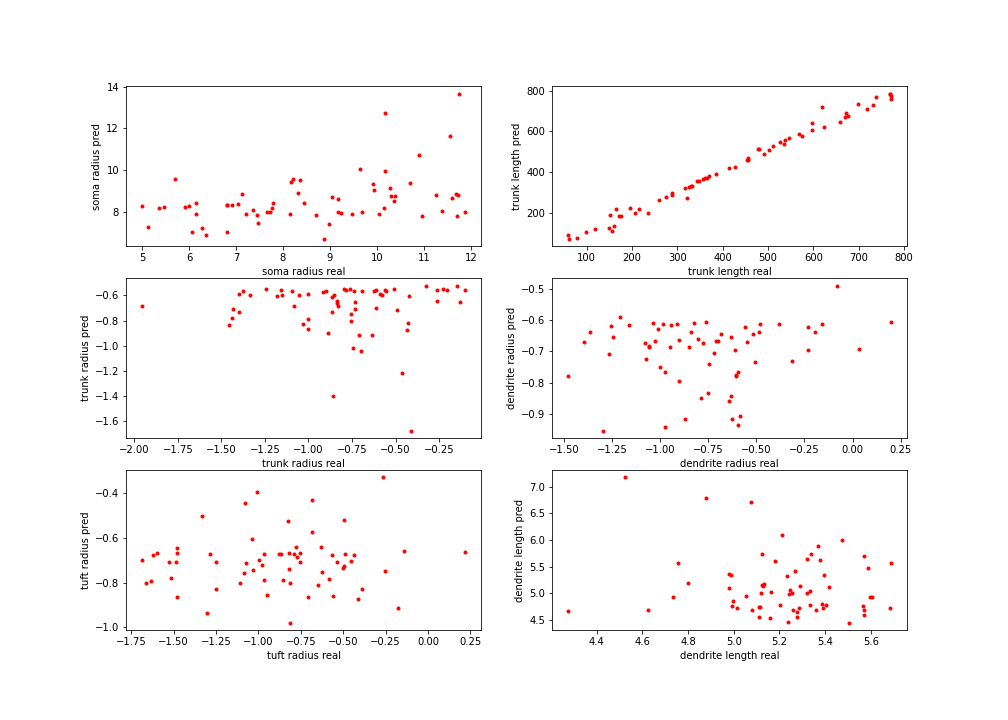

In [12]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))
#inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']

ax_s = plt.subplot(321)
ax_s.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_s.set_xlabel('soma radius real')
ax_s.set_ylabel('soma radius pred')

ax_t = plt.subplot(322)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('trunk length real')
ax_t.set_ylabel('trunk length pred')

ax_t = plt.subplot(323)
ax_t.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_t.set_xlabel('trunk radius real')
ax_t.set_ylabel('trunk radius pred')

ax_t = plt.subplot(324)
ax_t.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_t.set_xlabel('dendrite radius real')
ax_t.set_ylabel('dendrite radius pred')

ax_t = plt.subplot(325)
ax_t.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_t.set_xlabel('tuft radius real')
ax_t.set_ylabel('tuft radius pred')

ax_t = plt.subplot(326)
ax_t.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_t.set_xlabel('dendrite length real')
ax_t.set_ylabel('dendrite length pred')

plt.show()

In [ ]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()